In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_model import ARIMA, ARMAResults

import datetime
import sys
import seaborn as sns
import statsmodels
import statsmodels.stats.diagnostic as diag
from statsmodels.tsa.stattools import adfuller
from arch import arch_model
from scipy.stats.mstats import normaltest
from matplotlib.pyplot import acorr
%matplotlib inline
import quandl

/home/jacob/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
df = pd.read_csv("data/24h_candle.csv", delimiter=',', index_col=0)
df.head()

,id,date_time,open,close,low,high,volume,pair_id
#,,,,,,,,
1,10362847,2015-08-01 07:00:00.000000,284.000000,279.845023,275.724508,284.000000,301.376392,83
2,10362848,2015-08-02 07:00:00.000000,280.000000,286.438075,280.000000,286.438075,106.563859,83
3,10362849,2015-08-03 07:00:00.000000,285.438300,288.965644,284.286275,288.965644,75.706794,83
4,10362850,2015-08-04 07:00:00.000000,281.104486,288.000000,281.104486,288.000000,11.947218,83
5,10362851,2015-08-05 07:00:00.000000,288.200000,287.569800,279.793314,288.965425,9.297527,83


In [3]:
timeseries = df[['date_time','close', 'volume']][:-1]

In [4]:
timeseries['TSClose']= timeseries.close
timeseries['logTS']= np.log(timeseries['TSClose'])
timeseries['diflogTS'] = timeseries['logTS'] - timeseries['logTS'].shift(periods=-1)
timeseries = timeseries.dropna()

In [5]:
timeseries.tail()

,date_time,close,volume,TSClose,logTS,diflogTS
#,,,,,,
707,2017-07-07 07:00:00.000000,2477.000000,3.032787e+07,2477.000000,7.814803,-0.028760
708,2017-07-08 07:00:00.000000,2549.272532,2.205981e+07,2549.272532,7.843563,0.030330
709,2017-07-09 07:00:00.000000,2473.114739,1.449431e+07,2473.114739,7.813234,0.065637
710,2017-07-10 07:00:00.000000,2316.000000,4.587192e+07,2316.000000,7.747597,0.013915
711,2017-07-11 07:00:00.000000,2283.995523,5.741912e+07,2283.995523,7.733682,-0.039461


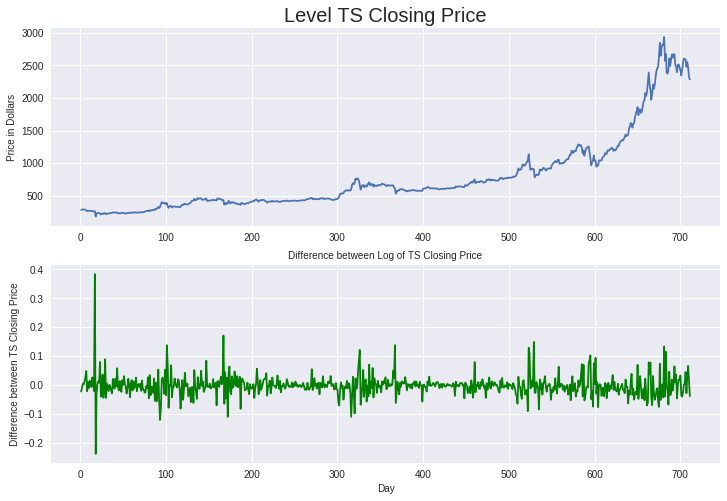

In [6]:
fig, ax = plt.subplots(figsize=(12,8))

plt.subplot(2, 1, 1)
plt.plot(timeseries.index, timeseries.TSClose, label = "Log of TS Closing Price")
plt.title("Level TS Closing Price", size = 20,)
plt.ylabel("Price in Dollars", size = 10)

plt.subplot(2, 1, 2)
plt.plot(timeseries.index, timeseries.diflogTS, label = '1st Diffrence of Log of TS', color = 'g')
plt.title("Difference between Log of TS Closing Price", size = 10,)
plt.ylabel("Difference between TS Closing Price", size = 10)
plt.xlabel('Day', size = 10)

Тест Дики-Фуллера для проверки стационарности ряда. Чем меньше значение р, тем больше ряд является стационарным

In [7]:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(timeseries.diflogTS, autolag='AIC')

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','# Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                 -30.762220
p-value                          0.000000
# Lags Used                      0.000000
Number of Observations Used    710.000000
Critical Value (1%)             -3.439594
Critical Value (5%)             -2.865619
Critical Value (10%)            -2.568942
dtype: float64


ARIMA (Auto-Regressive-Integrated-Moving-Average).

Уравнение прогнозирования ARIMA для стационарного временного ряда является линейным (то есть регрессионным), предсказатели состоят из лагов зависимой переменной и/или лагов ошибок прогноза. 

То есть:
Прогнозируемое значение Y = константа и/или взвешенная сумма одного или нескольких последних значений Y и/или взвешенной суммы одного или нескольких последних значений ошибок.

In [8]:
ararray = (timeseries.logTS.dropna().as_matrix())
p=0
q=0
d=1
pdq=[]
aic=[]

for p in range(3):
    for q in range(3):
        try:
            model = ARIMA(ararray, (p,d,q)).fit()
            x = model.aic
            x1 = (p,d,q)
            print (x1, x)
            aic.append(x)
            pdq.append(x1)
        except:
            pass
            
keys = pdq
values = aic
d = dict(zip(keys, values))
minaic=min(d, key=d.get)

for i in range(3):
    p=minaic[0]
    d=minaic[1]
    q=minaic[2]
print ("Best Model is :", (p,d,q))
ARIMIAmod = ARIMA(ararray, (p,d,q)).fit()

(0, 1, 0) -2663.02690605
(0, 1, 1) -2676.8099153774815
(0, 1, 2) -2675.1456084534207
(1, 1, 0) -2675.872186299441
(1, 1, 1) -2675.2241502253996
(2, 1, 0) -2674.8062755548385
(2, 1, 1) -2673.253312406549
(2, 1, 2) -2671.0388659768246
Best Model is : (0, 1, 1)


/home/jacob/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [9]:
numofsteps = 1
stepahead = ARIMIAmod.forecast(numofsteps)[0]
ferrors = ARIMIAmod.forecast(numofsteps)[2]
ferrors

print ('%s Steps Ahead Forecast  is:' % numofsteps, np.exp(stepahead))
print ('%s Steps Ahead 95 percent CI is:' % numofsteps, np.exp(ferrors[0])) #доверительный интервал для сделки


1 Steps Ahead Forecast  is: [ 2300.65966898]
1 Steps Ahead 95 percent CI is: [ 2141.48760155  2471.66264639]


In [10]:
df[['date_time','close', 'volume']].tail()

,date_time,close,volume
#,,,
709,2017-07-09 07:00:00.000000,2473.114739,1.449431e+07
710,2017-07-10 07:00:00.000000,2316.000000,4.587192e+07
711,2017-07-11 07:00:00.000000,2283.995523,5.741912e+07
712,2017-07-12 07:00:00.000000,2375.925000,4.011239e+07
713,2017-07-13 07:00:00.000000,2336.010066,1.062421e+07


In [11]:
timeseries.tail()

,date_time,close,volume,TSClose,logTS,diflogTS
#,,,,,,
707,2017-07-07 07:00:00.000000,2477.000000,3.032787e+07,2477.000000,7.814803,-0.028760
708,2017-07-08 07:00:00.000000,2549.272532,2.205981e+07,2549.272532,7.843563,0.030330
709,2017-07-09 07:00:00.000000,2473.114739,1.449431e+07,2473.114739,7.813234,0.065637
710,2017-07-10 07:00:00.000000,2316.000000,4.587192e+07,2316.000000,7.747597,0.013915
711,2017-07-11 07:00:00.000000,2283.995523,5.741912e+07,2283.995523,7.733682,-0.039461


In [12]:
numofsteps = 4
stepahead = ARIMIAmod.forecast(numofsteps)[0]
ferrors = ARIMIAmod.forecast(numofsteps)[2]
ferrors

print ('%s Steps Ahead Forecast  is:' % numofsteps, np.exp(stepahead))
print ('%s Steps Ahead 95 percent CI is:' % numofsteps, np.exp(ferrors[0])) #доверительный интервал для сделки


4 Steps Ahead Forecast  is: [ 2300.65966898  2307.47621885  2314.31296525  2321.16996803]
4 Steps Ahead 95 percent CI is: [ 2141.48760155  2471.66264639]
